With Constant Step Size

MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.01

Running  200000 iterations

The Policy is
(0,0) = 0.4835164835164835   (0,1) = 0.5164835164835165   
(1,0) = 0.48854961832061067   (1,1) = 0.5114503816793893   
(2,0) = 0.881578947368421   (2,1) = 0.11842105263157894   
(3,0) = 0.7980769230769231   (3,1) = 0.20192307692307693   
(4,0) = 0.2926829268292683   (4,1) = 0.7073170731707317   
(5,0) = 0.4430379746835443   (5,1) = 0.5569620253164557   
(6,0) = 0.88   (6,1) = 0.12   
(7,0) = 0.4715447154471545   (7,1) = 0.5284552845528455   
(8,0) = 0.30952380952380953   (8,1) = 0.6904761904761905   
(9,0) = 0.34328358208955223   (9,1) = 0.6567164179104478   
Approximately the limit [10.3269891, 10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007] 32.97217827875041


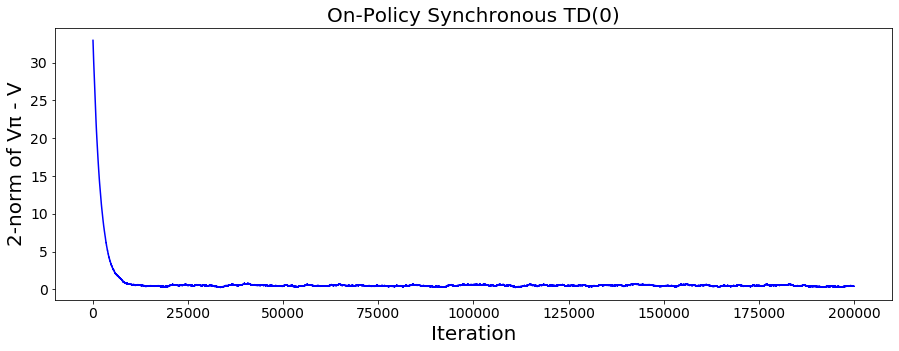

2-norm of Value function after TD Learning:   32.63813700313901 
 Actual value function vector:   [10.33897272 10.09099398 10.63665192 10.24107659 10.40067726 10.30366374
 10.52668019 10.22516709 10.30651631 10.12810773] 

Minimum:   0.2487475377254225


In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox.example
import random
import math
from collections import defaultdict


class SyncTDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, theta = 0.0001, iterations = 100000):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)

        #discount rate between [0,1]
        self.gamma = gamma

        #step size between [0,1]
        self.alpha = alpha

        #the mapping of states to actions
        self.policy = policy

        #amount of states and actions in the MDP
        self.states = states
        self.actions = actions
        
        #state space S
        self.state_space = np.arange(states)
        #action space A
        self.action_space = np.arange(actions)
        
        
        np.random.seed(0)
        #transition probability matrix P, in shape AxSxS'
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        
        # the reward Matrix, set default to random values between [0,1]
        self.rewardMatrix = np.random.rand(actions,states,states)

        #transition probability matrix based on policy
        self.probabilityMatrix = np.zeros((self.states,self.states))
        
        
        #for diminishing step size only with alpha and beta
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #theta value for value iteration must be a small positive number
        self.theta = theta
        
        #the value function that will be used for value iteration to find the value function limit
        #set it to the list that was found
        #must be same size as S
        self.v_pi =  [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]
        
        #list of 2-norm difference of v_pi - v
        self.norm_difference = []
        
        #number of iterations to run in the environment
        self.iterations = iterations
        
        #for debugging purposes
        #keep track how often each state gets visisted
        self.exploringStates = defaultdict(int)
        
        
        
    def setVpi(self,v_pi):
        """
        Set the estimated v_pi to what you found
        Must be called before running the environment
        Default reward matrix is set to what was found in value iteration
        
        For this to work
        :param v_pi: estimated v_pi, needs to be in length of state space S
        :returns: void
        """
        self.v_pi = v_pi
        
        
        
    def setRewardMatrix(self,matrix):
        """
        Change the reward matrix to whatever you want with this function
        
        For this to work
        Matrix needs to be in shape AxSxS
        A is the Action space
        S is the State space
        """
        self.rewardMatrix = matrix
        
    def createProbabilityMatrix(self):
        """
        Create the transition probability matrix based on the Policy pi 
        P(s1,s2) = sum a( P(s1,s2)*pi(a|s) )
        """
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.policy[s][a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state):
        
        """
        Using the transition probability matrix we created find the next state the agent is going to
        
        Just return the next state based on the transition probability matrix and the action taken
        Using random choice that will use a distribution to give a state
        :param state: observation that was previously seen
        :param action: action that was take
        :return: next state that the agent will go to 
    
        """    
        
        next_state = np.random.choice(self.state_space,1,p = self.probabilityMatrix[state])
        return next_state[0]


    def getValue(self,state):
        """
        Just return the value of the state action pair given the current estimate of the environment
        :param state: observation that was previously seen
        :param action: action that was take
        :return: the value of that state action pair
        """

        return self.value_function[state]

    def updateValueFunction(self,state, next_state,reward):
        """
        Update the action value function based on the
        :param state: previous state
        :param action: action taken at state
        :param next_state: next state the agent is planning on going ot
        :param next_action: if agent were at next_state the action the agent is planning on taking
        :param reward: the reward it received at state taking action
        :return: void,will change the q_function in the class

        using the on policy temporal difference formula
        V (S) ← V (S) + α[R + γV (S') − V (S)]
        """
        self.value_function[state] += self.step_size*(reward + self.gamma*(self.getValue(next_state))-self.getValue(state))


    def chooseAction(self, state):
        """
        Using the current state and the given policy find the action  using random choice based on the probabilities
        """
        
        p = []
        for action,prob in sorted(self.policy[state].items()):
            p.append(prob)
            
        action = np.random.choice(self.action_space, 1, p = p)
        
        return action[0]
    
    def takeAction(self,state,action):
        next_state = self.getNextState(state)
        reward = self.rewardMatrix[action][state][next_state]
        
        return next_state,reward
    
    
    def runEnvironment(self):
        """
        Will run the OpenGym AI environment set using on policy Temporal Difference Learning

        :return: difference list between v_pi and v

        """
        
        """
        Value iteration needs to be run before running this function
        Rough Estimate of the Value Function Limit
        [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]

        """
        
     
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        
        #starting a random reward
        state = np.random.randint(0,self.states)
        total_reward = 0
        actions = np.arange(self.actions)
        
        a = []
        pb = []
        for action, prob in self.policy.items():
            a.append(action)
            pb.append(prob)
        
        for t in range(self.iterations):

            #solve for the diminishing step size
            if self.diminish!=None and self.step_size>=0.001 and t>0:
                self.step_size = self.diminish(self.alpha, t, self.beta)

            #choose the action
            action = self.chooseAction(state)


            # update the V function with the new value
            for state in range(self.states):
                 # take the action into course
                next_state, reward = self.takeAction(state,action)
                
                #update the V(s)
                self.updateValueFunction(state,next_state, reward)
                
                self.exploring[next_state]+=1
                total_reward+= reward
            

            self.norm_difference.append(np.linalg.norm(self.v_pi - self.value_function))
        
    
    def plot(self):
        """
        For debugging and checking
        Provide Information on the Agent and MDP
        Plot the 2-norm difference between v_pi and v
        """
        
        #info on the MDP
        print(f"MDP with {self.states} states and {self.actions} actions\ndiscounting factor gamma = {self.gamma}, step size alpha = {self.step_size}\n")
        print("Running ", self.iterations, "iterations")
        
        #info on the policy
        print("\nThe Policy is")
        for s in range(self.states):
            for a in range(self.actions):
                print(f"({s},{a}) = {self.policy[s][a]}  ",end=" ")
            print()
        
        #plotting the 2-norm difference between v_pi and v
        print("Approximately the limit",self.v_pi, np.linalg.norm(self.v_pi))
        plt.figure(figsize = (15,5))
        plt.plot(range(self.iterations), self.norm_difference, 'b-')
            
        plt.title("On-Policy Synchronous TD(0)",fontsize = 20)
        plt.xlabel("Iteration",fontsize = 20)
        plt.ylabel("2-norm of Vπ - V",fontsize = 20)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.show()
        
        
        #info on the value function
        print("2-norm of Value function after TD Learning:  ", np.linalg.norm(self.value_function), "\n Actual value function vector:  ", self.value_function, "\n")
        print("Minimum:  ", min(self.norm_difference))
        
        
        
    
if __name__ == '__main__':
    
    """
    The Main Function to Run your program
    Example code given below
    All hyperparameters can be adjusted to your liking
    
    
    Policy must be given  
    the policy will be in the format of 
    (state,action) = Probability
    
    in python code it will be a dictionary inside of a dictionary
    {state: {action: probability of that action, action: probabiity, ... } state:{...}}
    """

    np.random.seed(0)
    iterations = 200000
    policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}

    
    print("With Constant Step Size\n")
    learner = SyncTDLearner(policy=policy,states = 10, actions = 2, iterations = iterations)
    learner.runEnvironment()
    learner.plot()
    
    print("\nWith Diminishing Step Size")
    learner = SyncTDLearner(policy=policy,states = 10, actions = 2, diminish = lambda a,k,b: a/(k**b), iterations = iterations)
    learner.runEnvironment()
    learner.plot()

